# Trump or Troll
## __Final Project:__ Shivam Jindal (sj2546) and Mayank Vanjani (mv1506)

Classify tweets sent by President Trump versus Russian trolls

__Note: This python notebook is the one we used on Google Colab to run the Neural Networks since it takes a while for those to complete training on our local machines__


# Initialize

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.feature_extraction import stop_words
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Activation, Flatten, Dropout
import tensorflow.keras.backend as K
from keras import regularizers
from PIL import Image

# Data Input

trump_tweets_df is a dataframe containing all of the trump tweets from our dataset  
troll_tweets_df is a dataframe containing all of the troll tweets from our dataset

In [0]:

df = pd.read_excel("https://github.com/mayankvanjani/trump_or_troll/blob/master/TrumpTwitterAll.xlsx?raw=true")
df2 = pd.read_csv("https://raw.githubusercontent.com/mayankvanjani/trump_or_troll/master/IRAhandle_tweets_1.txt")


# Data Pre-Processing


### Extracting the Tweets

In [303]:
print(df.shape)
print(df2.shape)
print()
print("df: Trump Tweet Headers")
print(df.columns)
print()
print("df2: Troll Tweet Headers")
print(df2.columns)
#df.head(5)

trump_tweets_df = df["Tweet"]

# We want the same amount of the number of trump tweets
troll_tweets_df = df2["content"][:30078]

(30078, 5)
(243891, 21)

df: Trump Tweet Headers
Index(['Date', 'Time', 'Tweet', 'Client', 'Client Simplified'], dtype='object')

df2: Troll Tweet Headers
Index(['external_author_id', 'author', 'content', 'region', 'language',
       'publish_date', 'harvested_date', 'following', 'followers', 'updates',
       'post_type', 'account_type', 'retweet', 'account_category',
       'new_june_2018', 'alt_external_id', 'tweet_id', 'article_url',
       'tco1_step1', 'tco2_step1', 'tco3_step1'],
      dtype='object')


### Examining the tweets

In [304]:
trump_tweets_df.head(5)

0    If the press would cover me accurately & honor...
1    I am thrilled to nominate Dr. @RealBenCarson a...
2    their country (the U.S. doesn't tax them) or t...
3    Did China ask us if it was OK to devalue their...
4    .@FoxNews will be re-running "Objectified: Don...
Name: Tweet, dtype: object

In [305]:
troll_tweets_df.head(5)

0    "We have a sitting Democrat US Senator on tria...
1    Marshawn Lynch arrives to game in anti-Trump s...
2    Daughter of fallen Navy Sailor delivers powerf...
3    JUST IN: President Trump dedicates Presidents ...
4    19,000 RESPECTING our National Anthem! #StandF...
Name: content, dtype: object

# Preparing the tweets: 

- The vectorizer creates a sparse matrix with the top 5000 features (i.e. different types of words and their TFIDF scores)
- We decided to use a tfidfvectorizer because we care about understanding what words matter. Understanding frequency of the words is pretty useful for this application


In [306]:
vectorizer = TfidfVectorizer( 
                max_df=0.75, 
                min_df=2,   
                max_features=5000,    
                stop_words='english', 
                use_idf=True )        

# first half are Trump tweets, second half are Troll tweets
all_my_tweeties = trump_tweets_df.append(troll_tweets_df)
all_my_tweeties.head(5)

# Use TFIDF to numericalize importance of words within the tweet
X = vectorizer.fit_transform(all_my_tweeties)
terms = vectorizer.get_feature_names()
X.shape

(60156, 5000)

# KMeans

- We define a KMeans Class with 2 clusters (one for Trump's tweets and one for Troll's tweets)

In [0]:
km = KMeans(n_clusters=2, init='k-means++', n_init=1, random_state=42)

In [308]:
km.fit(X)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=2, n_init=1, n_jobs=None, precompute_distances='auto',
       random_state=42, tol=0.0001, verbose=0)

### Output the 10 largest components in each cluster

In [309]:
order_centroids = km.cluster_centers_.argsort()[:, ::-1]
for i in range(2):
    print("Cluster %d:" % i, end='')
    for ind in order_centroids[i, :20]:
        print(' %s' % terms[ind], end='')
    print()

Cluster 0: http realdonaldtrump thanks trump great president thank https donald just people like don good obama run love america make time
Cluster 1: https enlist di на il la amp army video thank trump patriot mj4n1lcxvf usfa rt join gt trump2016 blacklivesmatter acapa


Looking at the code above, it makes sense that those are the two clusters. 

- Donald Trump tweets are likely to contain words talking about him 
- Russian Troll tweets may have terms relevant to American politics but also have gibberish that they repeat a lot

### Confusion Matrix

This just gives us the labels of Donald Trump tweets and Russian Troll tweets. 

In [0]:
first_half = np.zeros(30078) #Trump (0)
second_half = first_half+1 #Troll (1)

labels = np.append(first_half, second_half)

This gives us a confusion matrix which we can use to understand how well our KMeans algorithm managed to cluster the tweets

In [311]:
labelkm = km.labels_
from sklearn.metrics import confusion_matrix
C = confusion_matrix(labels,labelkm, labels=[0, 1])


Csum = np.sum(C, axis=0)
Cnorm = C / Csum[None,:]
print(Cnorm)

[[0.67355768 0.07335441]
 [0.32644232 0.92664559]]


This is quite interesting. It's really good at classifying troll tweets as trolls, but has a lot of misclassifications of the Trump tweets.  


### Overall Accuracy of KMeans

In [312]:
print("Accuracy of KMeans =", str((C[0,0] + C[1,1])/np.sum(C)))

Accuracy of KMeans = 0.746741804641266


# Neural Network

### NN Setup

Want to use the same X data to train a Neural Network as follows:

In [0]:
Xtr, Xts, ytr, yts = train_test_split(X, labels, test_size=0.5, random_state=42)

In [314]:
K.clear_session()
from keras.regularizers import l2
from keras.regularizers import l1

nin = Xtr.shape[1]
print(nin)
print(Xtr.shape)
nh = 100

nout = 1
model = Sequential()


model.add(Dense(units=500, input_shape=(nin,), activation='relu', name='hidden1'))
model.add(Dense(units=500, input_shape=(500,), activation='relu', name='hidden2'))
model.add(Dense(units=100, input_shape=(500,), activation='relu', name='hidden3'))
model.add(Dense(units=nout, activation='sigmoid', name='output'))

'''
model.add(Dense(units=500, input_shape=(nin,), activation='relu', name='hidden1',
                kernel_regularizer=l2(0.015), bias_regularizer=l2(0.015)))
model.add(Dropout(0.4, input_shape=(nin,)))
model.add(Dense(units=500, input_shape=(500,), activation='relu', name='hidden2',
                kernel_regularizer=l2(0.015), bias_regularizer=l2(0.015)))
model.add(Dropout(0.4, input_shape=(nin,)))
model.add(Dense(units=100, input_shape=(500,), activation='relu', name='hidden3',
                kernel_regularizer=l2(0.015), bias_regularizer=l2(0.015)))
model.add(Dense(units=nout, activation='sigmoid', name='output'))

'''

5000
(30078, 5000)


"\nmodel.add(Dense(units=500, input_shape=(nin,), activation='relu', name='hidden1',\n                kernel_regularizer=l2(0.015), bias_regularizer=l2(0.015)))\nmodel.add(Dropout(0.4, input_shape=(nin,)))\nmodel.add(Dense(units=500, input_shape=(500,), activation='relu', name='hidden2',\n                kernel_regularizer=l2(0.015), bias_regularizer=l2(0.015)))\nmodel.add(Dropout(0.4, input_shape=(nin,)))\nmodel.add(Dense(units=100, input_shape=(500,), activation='relu', name='hidden3',\n                kernel_regularizer=l2(0.015), bias_regularizer=l2(0.015)))\nmodel.add(Dense(units=nout, activation='sigmoid', name='output'))\n\n"

In [315]:
#model.build((nin,))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
hidden1 (Dense)              (None, 500)               2500500   
_________________________________________________________________
hidden2 (Dense)              (None, 500)               250500    
_________________________________________________________________
hidden3 (Dense)              (None, 100)               50100     
_________________________________________________________________
output (Dense)               (None, 1)                 101       
Total params: 2,801,201
Trainable params: 2,801,201
Non-trainable params: 0
_________________________________________________________________


### Training

In [316]:
from tensorflow.keras import optimizers
opt = optimizers.Adam(lr = 0.001)
model.compile(optimizer=opt,
             loss='binary_crossentropy', 
             metrics=['accuracy'])
#'mean_squared_error'
hist = model.fit(Xtr, ytr, epochs=15, batch_size=100, validation_data=(Xts.A, yts))

Train on 30078 samples, validate on 30078 samples
Epoch 1/15
30078/30078 [==============================] - 16s 530us/sample - loss: 0.2093 - acc: 0.9196 - val_loss: 0.1502 - val_acc: 0.9419
Epoch 2/15
30078/30078 [==============================] - 16s 530us/sample - loss: 0.0876 - acc: 0.9688 - val_loss: 0.1687 - val_acc: 0.9410
Epoch 3/15
30078/30078 [==============================] - 16s 531us/sample - loss: 0.0416 - acc: 0.9859 - val_loss: 0.2223 - val_acc: 0.9376
Epoch 4/15
30078/30078 [==============================] - 16s 528us/sample - loss: 0.0234 - acc: 0.9913 - val_loss: 0.2897 - val_acc: 0.9378
Epoch 5/15
30078/30078 [==============================] - 16s 528us/sample - loss: 0.0162 - acc: 0.9938 - val_loss: 0.3056 - val_acc: 0.9393
Epoch 6/15
30078/30078 [==============================] - 16s 529us/sample - loss: 0.0128 - acc: 0.9953 - val_loss: 0.3426 - val_acc: 0.9399
Epoch 7/15
30078/30078 [==============================] - 16s 530us/sample - loss: 0.0116 - acc: 0.9962 

### Plotted Graphs

[0.91957575, 0.96881443, 0.9859033, 0.9913226, 0.99384934, 0.9953122, 0.9962431, 0.9963096, 0.99614334, 0.99577767, 0.9960436, 0.9962763, 0.99634284, 0.9966753, 0.99677503]
[0.9418512, 0.94102, 0.9376288, 0.93776184, 0.9392912, 0.9398896, 0.93985635, 0.93879247, 0.9360662, 0.9380278, 0.93912494, 0.9393577, 0.9390252, 0.9386595, 0.94188446]


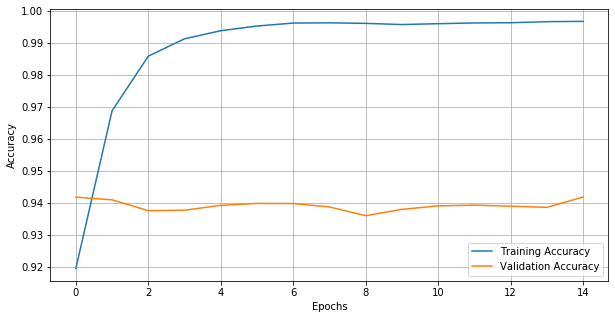

In [317]:
tr_accuracy = hist.history['acc']
val_accuracy = hist.history['val_acc']
print(tr_accuracy)
print(val_accuracy)

figure(figsize=(10,5))
plt.plot(tr_accuracy)
plt.plot(val_accuracy)
plt.grid()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Training Accuracy', 'Validation Accuracy'])

[0.20928946303739868, 0.0875938927778416, 0.04161123831980775, 0.023394073909240844, 0.01622174734991707, 0.012822820557786406, 0.011633444253805067, 0.010993644108376438, 0.011491806180302941, 0.012265580233397392, 0.011265069660971867, 0.010917955021950872, 0.010629494748606666, 0.009444914341592373, 0.009063344597500436]
[0.150210885090138, 0.16872562416602824, 0.22227764575960107, 0.28969682388966767, 0.3056077731650518, 0.3425907214936428, 0.36456390230509145, 0.37092494178818247, 0.3827191495830585, 0.37007840975090556, 0.4065294239759956, 0.4083733910792439, 0.4194311990160318, 0.38019490741273554, 0.4569195213105471]


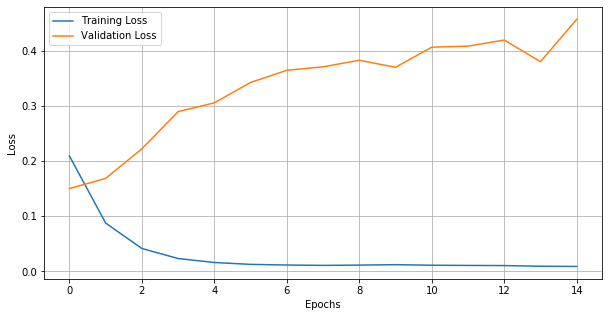

In [318]:
tr_loss = hist.history['loss']
val_loss = hist.history['val_loss']
print(tr_loss)
print(val_loss)

figure(figsize=(10,5))
plt.plot(tr_loss)
plt.plot(val_loss)
plt.grid()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Training Loss', 'Validation Loss'])

# Word Clouds

Just for fun visualizations, we want to see a word cloud of the common words in Trump's tweets and in Troll's tweets  

We want to not include basic stop words. Also want to get rid of https because this doesn't tell us much....

In [0]:
from wordcloud import WordCloud, STOPWORDS 
stopwords = set(STOPWORDS)
stopwords.update(["https", "co"])


# This extra stuff allows us to create a pretty fun word cloud with Trump's silhouette
from PIL import Image
import requests
from io import BytesIO

response = requests.get("https://github.com/mayankvanjani/trump_or_troll/raw/master/trump.png")
response2 = requests.get("https://github.com/mayankvanjani/trump_or_troll/raw/master/trump2.png")
img = np.array(Image.open(BytesIO(response.content)).convert("L"))
img = np.where(img == 254, 255, img)
img2 = np.array(Image.open(BytesIO(response2.content)).convert("L"))
img2 = np.where(img2 == 254, 255, img2)

## This displays the terms with the highest TFIDF scores in post 1000 (one of Donald Trump's Posts)

We are doing this to just get an idea of what TFIDF does within a tweet and to show individual tweet influence on the overall word cloud

In [320]:
doc_ind = 1000  # Index of an example document
xi = X[doc_ind,:].todense()
term_ind = xi.argsort()[:, ::-1]
xi_sort = xi[0,term_ind]
#terms = vectorizer.get_feature_names()

for i in range(10):
    term = terms[term_ind[0,i]]
    tfidf = xi[0,term_ind[0,i]]
    print('{0:20s} {1:f} '.format(term, tfidf))

labor                0.428762 
mike_pence           0.412798 
hosting              0.394354 
maga                 0.355841 
leaders              0.342455 
post                 0.329780 
american             0.284062 
thank                0.217162 
https                0.098706 
foxandfriends        0.000000 


## Donald Trump Tweet Word Cloud

In [0]:
full_trump_text = " ".join([tweet.lower() for tweet in trump_tweets_df])

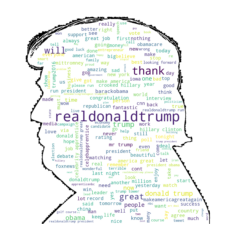

In [322]:
wordcloud = WordCloud(stopwords=stopwords, background_color="white", mask=img, contour_width=3, contour_color="black").generate(full_trump_text)
wordcloud.to_file("trump_tweets_wc.png")

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

## Troll Tweet Word Cloud

In [0]:
full_troll_text = " ".join([tweet.lower() for tweet in troll_tweets_df])

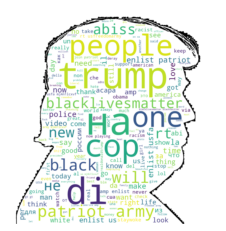

In [324]:
wordcloud = WordCloud(stopwords=stopwords, background_color="white", mask=img2, contour_width=3, contour_color="black").generate(full_troll_text)
wordcloud.to_file("troll_tweets_wc.png")

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()